In [65]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [66]:
!pip install tensorflow


In [67]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from optuna.visualization import plot_slice
from sklearn.neural_network import MLPClassifier
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import warnings
warnings.filterwarnings('ignore')
sns.set()
plt.style.use('ggplot')
%matplotlib inline

In [4]:
df=pd.read_csv('indian_liver_patient.csv')

In [6]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [71]:
df.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


## #  EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [8]:
df.dtypes[df.dtypes=='object']

Gender    object
dtype: object

In [9]:
def convertdataset(x):
    if x==2:
        return 0
    return 1
df['Dataset'] = df['Dataset'].map(convertdataset)

In [10]:
df.Dataset.value_counts()

Dataset
1    416
0    167
Name: count, dtype: int64

In [11]:
df['Gender'].value_counts()

Gender
Male      441
Female    142
Name: count, dtype: int64

In [77]:
# Categorical Value Handling
def convertgender(x):
    if x== 'Male':
        return 0
    else:
        return 1
df['Gender'] = df['Gender'].map(convertgender)

In [78]:
df = df.drop_duplicates()

In [79]:
df.shape

(570, 11)

In [12]:
# Let's first check what columns are present in the DataFrame
print("Columns in the DataFrame:", df.columns)

# If we expect a 'Diagnosis' column but it's not there, let's find the closest match to it
import difflib
expected_column = 'Diagnosis'
columns = df.columns

# Use difflib to find the closest column name to 'Diagnosis'
closest_match = difflib.get_close_matches(expected_column, columns, n=1)

# Print the closest match if found
if closest_match:
    print(f"Did you mean: {closest_match[0]}?")
else:
    print(f"No similar columns found for: {expected_column}")

# If a similar column was found, let's use it to clean the data
if closest_match:
    diagnosis_column = closest_match[0]
    # Clean the column by stripping leading/trailing spaces and converting to lowercase
    df[diagnosis_column] = df[diagnosis_column].str.strip().str.lower()

    # Print the first few rows of the cleaned DataFrame
    print("\nCleaned DataFrame:")
    print(df.head())


Columns in the DataFrame: Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')
No similar columns found for: Diagnosis


In [14]:
# Divide features into categorical and numerical
categorical_features = ['Gender']
numerical_features = ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                      'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 
                      'Albumin', 'Albumin_and_Globulin_Ratio']

# Handle missing values for numerical features by filling with the median
for feature in numerical_features:
    df[feature] = df[feature].fillna(df[feature].median())

# Convert numerical features to int32 for optimization
for feature in numerical_features:
    df[feature] = df[feature].astype('int32')

# Convert categorical features to the category data type
for feature in categorical_features:
    df[feature] = df[feature].astype('category')

# Check the result
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Age                         583 non-null    int32   
 1   Gender                      583 non-null    category
 2   Total_Bilirubin             583 non-null    int32   
 3   Direct_Bilirubin            583 non-null    int32   
 4   Alkaline_Phosphotase        583 non-null    int32   
 5   Alamine_Aminotransferase    583 non-null    int32   
 6   Aspartate_Aminotransferase  583 non-null    int32   
 7   Total_Protiens              583 non-null    int32   
 8   Albumin                     583 non-null    int32   
 9   Albumin_and_Globulin_Ratio  583 non-null    int32   
 10  Dataset                     583 non-null    int64   
dtypes: category(1), int32(9), int64(1)
memory usage: 25.9 KB
None


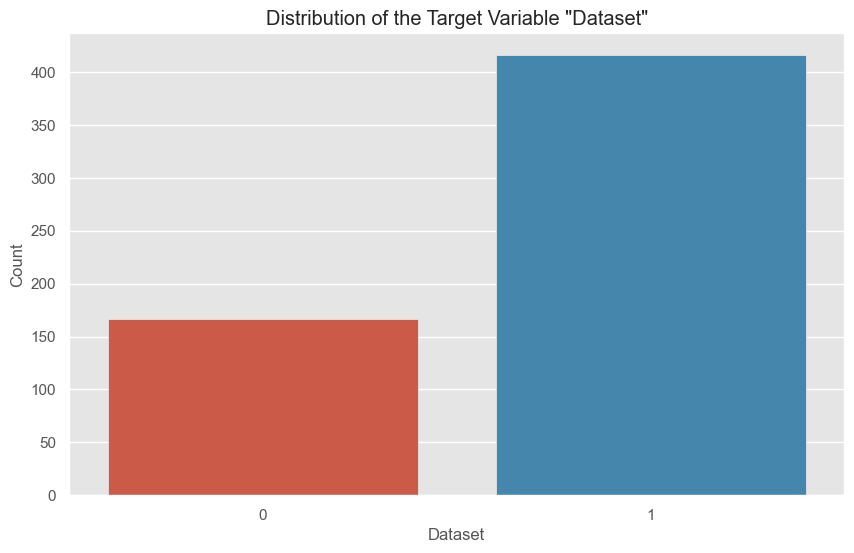

In [15]:
# Plot the distribution of the target variable "Dataset"
plt.figure(figsize=(10, 6))
sns.countplot(x='Dataset', data=df)
plt.title('Distribution of the Target Variable "Dataset"')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.show()

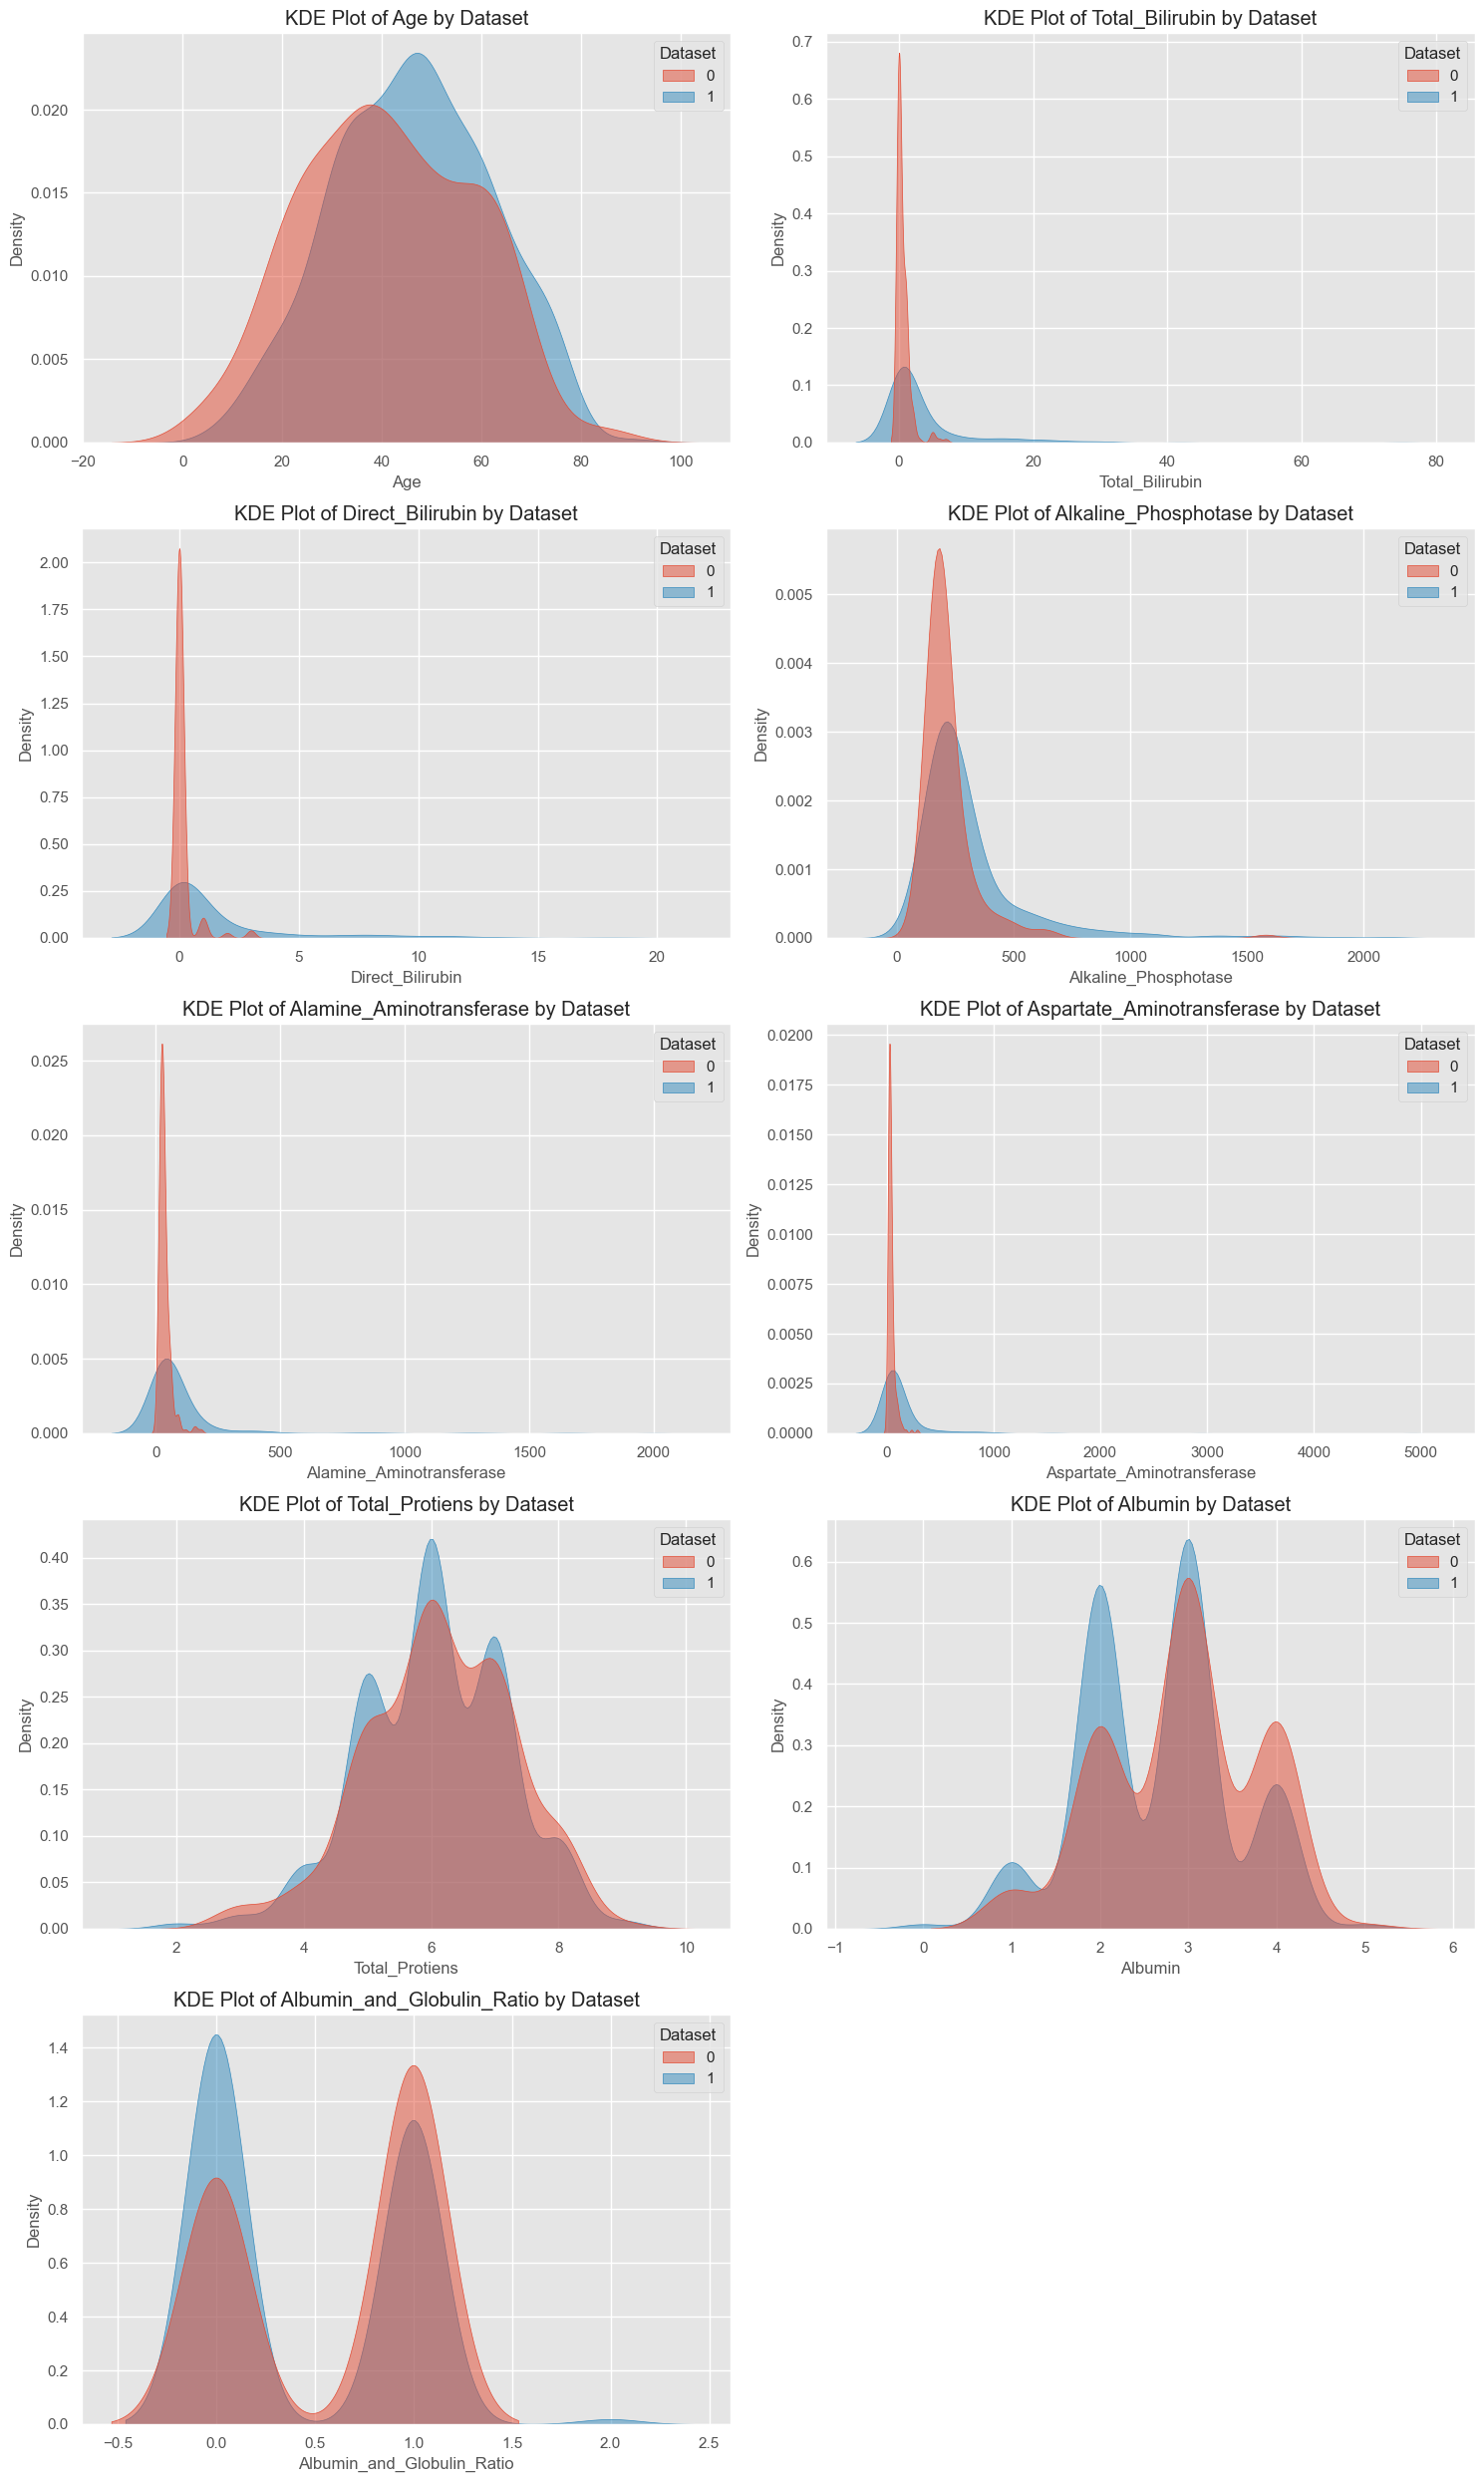

In [16]:
# List of numerical features
numerical_features = ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
                      'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens',
                      'Albumin', 'Albumin_and_Globulin_Ratio']

# Plot KDE for each numerical feature against the target variable "Dataset"
plt.figure(figsize=(15, 25))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(5, 2, i)
    sns.kdeplot(data=df, x=feature, hue='Dataset', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'KDE Plot of {feature} by Dataset')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


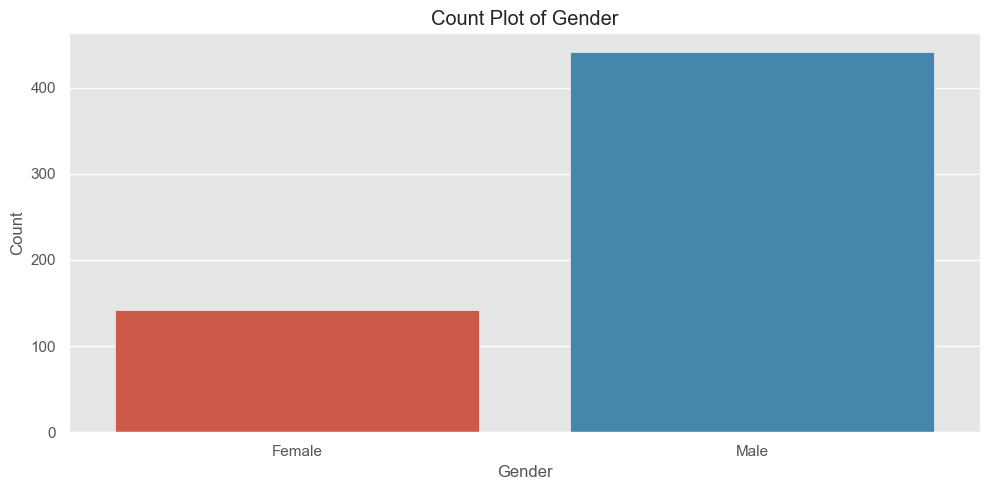

In [17]:
# List of categorical features
categorical_features = ['Gender']

# Plot count plots for each categorical feature
plt.figure(figsize=(10, 5))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, len(categorical_features), i)
    sns.countplot(x=feature, data=df)
    plt.title(f'Count Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


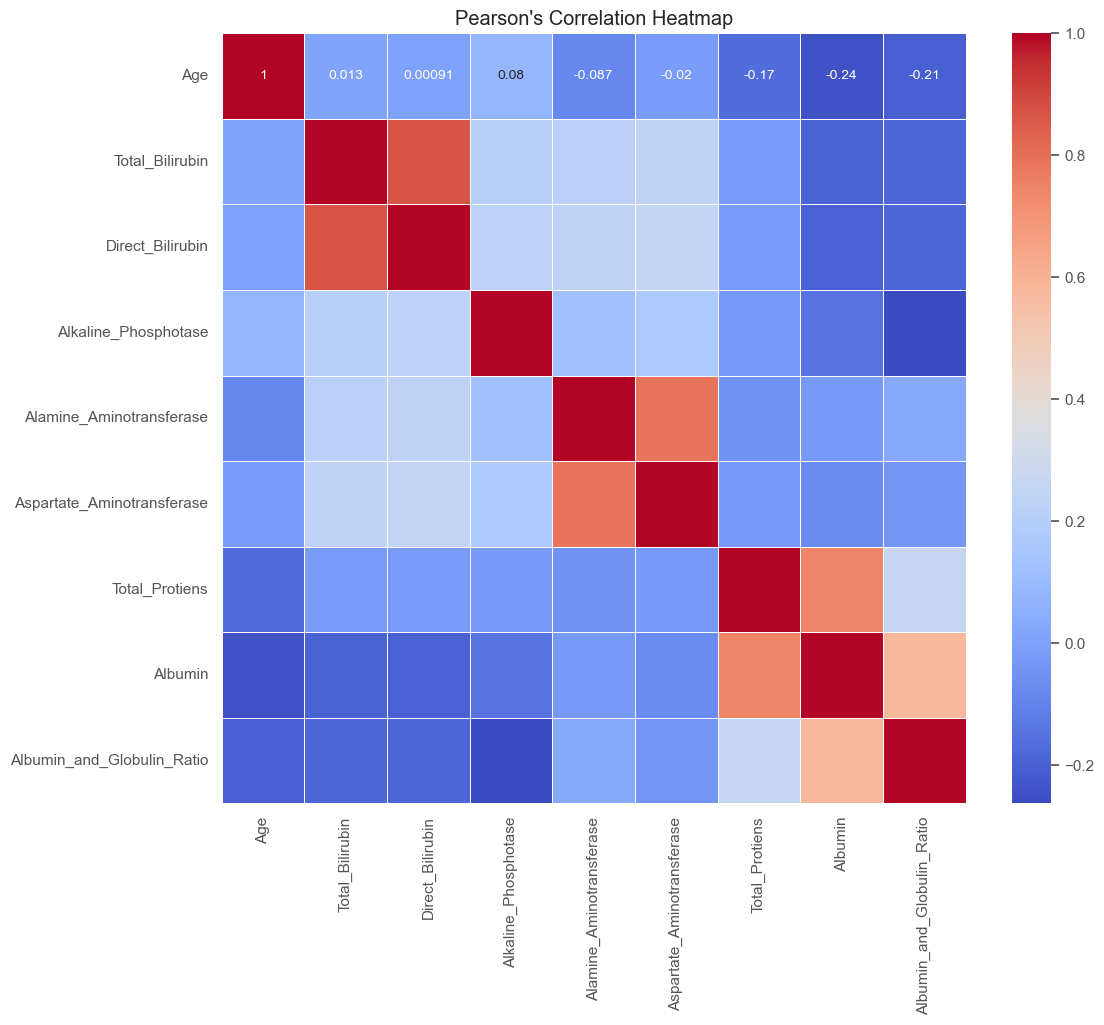

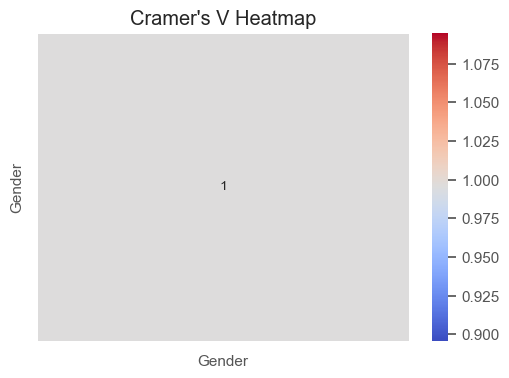

In [18]:
from scipy.stats import chi2_contingency

# Calculate Pearson's correlation coefficient for numerical features
numerical_features = ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                      'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 
                      'Albumin', 'Albumin_and_Globulin_Ratio']

# Pearson's correlation coefficient
corr_matrix = df[numerical_features].corr(method='pearson')

# Plot heatmap for Pearson's correlation coefficient
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Pearson's Correlation Heatmap")
plt.show()

# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calculate Cramer's V for categorical features
categorical_features = ['Gender']
cramers_v_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for feature in categorical_features:
    cramers_v_matrix.loc[feature, feature] = cramers_v(df[feature], df[feature])

# Plot heatmap for Cramer's V
plt.figure(figsize=(6, 4))
sns.heatmap(cramers_v_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Cramer's V Heatmap")
plt.show()


<Axes: >

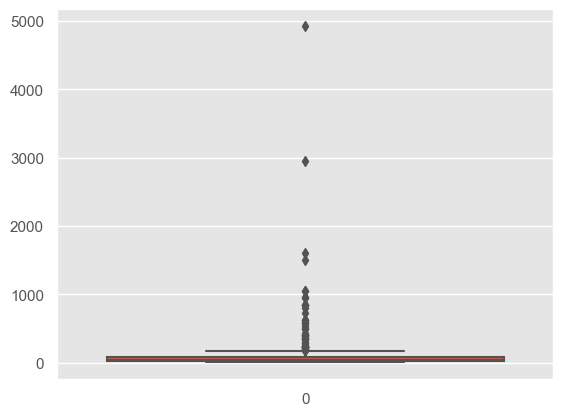

In [80]:
sns.boxplot(df.Aspartate_Aminotransferase)

In [81]:
df.Aspartate_Aminotransferase.sort_values(ascending=False).head()

135    4929
117    2946
118    1600
207    1500
199    1050
Name: Aspartate_Aminotransferase, dtype: int64

In [82]:
df = df[df.Aspartate_Aminotransferase<=3000]

In [83]:
df.shape

(569, 11)

In [84]:
df.Aspartate_Aminotransferase.sort_values(ascending=False).head()

117    2946
118    1600
207    1500
119    1050
199    1050
Name: Aspartate_Aminotransferase, dtype: int64

In [85]:
df = df[df.Aspartate_Aminotransferase<=2500]

In [86]:
df.shape

(568, 11)

In [87]:
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [88]:
df = df.dropna(how='any')